<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#NB-description" data-toc-modified-id="NB-description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>NB description</a></span></li><li><span><a href="#The-dotsPositions.csv-data" data-toc-modified-id="The-dotsPositions.csv-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The dotsPositions.csv data</a></span></li><li><span><a href="#Write-a-dotsDB-HDF5-file" data-toc-modified-id="Write-a-dotsDB-HDF5-file-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Write a dotsDB HDF5 file</a></span><ul class="toc-item"><li><span><a href="#Write-HDF5-file" data-toc-modified-id="Write-HDF5-file-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Write HDF5 file</a></span></li></ul></li><li><span><a href="#Diagnostic" data-toc-modified-id="Diagnostic-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Diagnostic</a></span></li></ul></div>

# NB description
date: 12 Dec 2019  
This notebook contains code that:
- builds an HDF5 dotsDB database off of dotsPositions.csv files from the Fall 2019 data (subjects 10-13)

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import seaborn as sns
import h5py     
import os.path

# add location of custom modules to path
sys.path.insert(0,'../modules/')
sys.path.insert(0,'../modules/dots_db/dotsDB/')

# custom modules
import dotsDB as ddb
import motionenergy as kiani_me
import stimulus as stim
import ME_functions as my_me
from basic_functions import *

# The dotsPositions.csv data
With the current pipeline, on the day of the session, a `.csv` file is written to disk with the FIRA data. Then, in the `motion_energy_Adrian` repo, I have MATLAB functions `reproduce_dots` and `batch_reproduce_dots` that write `_dotsPositions.csv` files to disk (one file per session).

The first step here is to loop through the completed sessions, perform a `join` of the dots and fira data, and update a global `.csv` file, as well as session-specific `.csv` files, called `labeled_dots_<timestamp>.csv`.

In [ ]:
!find /home/adrian/SingleCP_DotsReversal/Fall2019/raw -name "*dotsPositions.csv" -print

In [ ]:
!find /home/adrian/SingleCP_DotsReversal/Fall2019/raw -name "completed*100*.csv" -print

In [ ]:
'''
list of written data timestamps:
'2019_11_06_12_43'
'2019_11_05_16_19',
'2019_11_20_15_34',
'2019_11_19_13_15',
'2019_11_05_13_18',
'2019_11_26_13_11',
'2019_11_25_16_12',

list of problematic timestamps that were NOT written
'2019_11_05_10_27'  (subject=10 probCP=0.3)
'''
TIMESTAMPS = ('2019_12_11_12_21',)

In [2]:
DATA_FOLDER = '/home/adrian/SingleCP_DotsReversal/Fall2019/raw/'

The fira dataframe has index ranging from 0 to 819. The next step is to create a "foreign key" to this index into the dots dataframe.

In [3]:
DOTS_LABELED = '/home/adrian/SingleCP_DotsReversal/Fall2019/processed/dots_fall_2019_v2.csv'

In [ ]:
# this step with write to the DOTS_LABELED file, which contains labeled dots info necessary to dump to HDF5
if True:
    label_dots(TIMESTAMPS, DOTS_LABELED, DATA_FOLDER)

# Write a dotsDB HDF5 file
Now that all the dotsPositions.csv data is collected into a single global .csv file, I wish to dump it all into an hdf5 database.

Several actions need to be implemented.
1. For each trial in the dotsPositions.csv data, I need to know: _coherence_, _viewing duration_, _presenceCP_, _direction_, _subject_, _block_ (_probCP_). For this, I will assume that the `trialEnd` (from FIRA) and `seqDumpTime` (from dotsPositions) timestamps are in the same unit.
2. I need to decide how to organize my dotsDB hierarchically. Example is `subj15/probCP0.1/coh0/ansleft/CPno/VD100`

So far so good, for a given `seqDumpTime` value, I am able to recover the trial's parameters. All that remains to do is to add columns to the dots dataframe (and remove the `isActive` one).

**Following cell is SLOW! Around 30 min**

I forgot to record true duration and subject's choice!
Rebelote...

I should have added `dirChoice` instead of `cpChoice`!!!

Now, it turns out some rows have a `nan` value in the `dirChoice` column!
I will drop them!

## Write HDF5 file
Now, I need to write an HDF5 file with the structure:
`subj15/probCP0.1/coh0/ansleft/CPno/VD100`.

I need to:
- loop through the trials contained in the dots DF
- port the dots data to dotsDB format
- write to file

In [4]:
dots = pd.read_csv(DOTS_LABELED)

In [ ]:
dots.head()

In [ ]:
dots.shape

In [ ]:
dots.columns

In [ ]:
# important to only select the dates that we want to write to the HDF5 file
dots = dots[dots['date'] == 201912111221]

In [ ]:
gb = dots.groupby('trialEnd')  # recall gb.get_group() and gb['frameIdx'].max()

At this stage, I would like to know the max value of `frameIdx` in each trial.

Following cell takes a bit under 9 min

In [8]:
# Recall func is called twice the first time!
h5_filename = '/home/adrian/SingleCP_DotsReversal/Fall2019/processed/fall2019_v2.h5'
if False:  # just a failsafe not to run this cell by mistake
    _ = gb.apply(write_dots_to_file, h5_filename)
    
    # need to go in manually and delete the first entry in the dataset corresponding to 
    # the first group element gb.groups.keys()[0] 
    single_row = dots[dots['trialEnd']==list(gb.groups.keys())[0]]
    pb_dset_name, vals = get_group_name(single_row)
    pb_dset_name += '/px'
    f = h5py.File(h5_filename, 'r+')  # read/write
    d = f[pb_dset_name]
    d = d[1:]  # override first trial
    f.__delitem__(pb_dset_name)
    f[pb_dset_name] = d
    f.close()

In [5]:
# tend = list(gb.groups.keys())[0]
fira = pd.read_csv(DATA_FOLDER + 'full_2019_12_11.csv')
fira.head()

,taskID,trialIndex,trialStart,trialEnd,RT,cpRT,dirChoice,cpChoice,dirCorrect,cpCorrect,...,blankScreen,feedbackOn,subject,date,probCP,cpScreenOn,dummyBlank,reversal,duration,finalDuration
0,100,1,2.131056e+06,2.131063e+06,0.213185,2.864000,0,0,1,1,...,2.131063e+06,NaN,10,201911051318,0.7,3.290608,6.155014,0.0,0.40,NaN
1,100,2,2.131064e+06,2.131066e+06,0.458183,0.815998,1,0,0,0,...,2.131066e+06,NaN,10,201911051318,0.7,1.761605,2.575164,0.2,0.25,NaN
2,100,3,2.131067e+06,2.131070e+06,0.413732,0.735999,1,0,1,1,...,2.131070e+06,NaN,10,201911051318,0.7,1.412050,2.140863,0.0,0.20,NaN
3,100,4,2.131071e+06,2.131074e+06,0.357103,1.112000,1,0,0,1,...,2.131074e+06,NaN,10,201911051318,0.7,1.975471,3.077166,0.0,0.40,NaN
4,100,5,2.131075e+06,2.131077e+06,0.494251,0.567998,1,0,0,0,...,2.131077e+06,NaN,10,201911051318,0.7,1.485211,2.044533,0.2,0.25,NaN


In [ ]:
fira[fira['date'] == 201911261311]['probCP'].unique()

In [ ]:
fira['direction'].unique()

In [ ]:
fira['dirChoice'].unique()

In [ ]:
fira[fira['trialEnd'] == tend][['subject', 'dirChoice', 'duration', 'probCP', 'direction', 'coherence', 'reversal']]

In [ ]:
fira.dtypes

In [ ]:
fira[
    (fira['subject'] == 10) & 
    (fira['probCP'] == 0.7) & 
    (fira['coherence'] == 61) & 
    (fira['dirChoice'] == 1) & 
    (fira['reversal'] == 0.2) & 
    (fira['duration'] == .4) & 
    (fira['direction'] == 0)
]

In [ ]:
print(pb_dset_name[1:])
print(count_trials_fira(pb_dset_name[1:], fira))

The fact that only 4 trials correspond to the dataset for which the HDF5 length was doubled during the dump procedure is worrying.

In [ ]:
particular_dset = dots[
    (dots['subject'] == 10) & (dots['probCP'] == 0.7) & (dots['coherence'] == 61) \
    & (dots['dirChoice'] == 0) & (dots['reversal'] == 0.2) & (dots['viewingDuration'] == .4) & \
    (dots['initDirection'] == 0)
]

In [ ]:
particular_dset.head()

In [ ]:
particular_dset.shape

In [ ]:
particular_dset['trialIx'].unique()

# Diagnostic

In [ ]:
not(any([len(dd) for dd in d[-47:]]))

In [ ]:
first_fifty_three = [len(dd) for dd in d[:53]]
all(first_fifty_three)

In [ ]:
print('min ', min(first_fifty_three), ' max ', max(first_fifty_three))

In [ ]:
a=f[pb_dset_name[:-3]]

In [ ]:
(a.attrs['frame_width_in_pxs'] ** 2) * round(.4 * 60)

In [ ]:
(a.attrs['frame_width_in_pxs'] ** 2) * round(.437 * 60)

The last 47 items in the problematic dataset are empty and the first 53 are not. Each trial has a number of frames corresponding to some duration between 400 and 437 msec.

It appears that 2 out of the three unique trials in the dataset (one of them is trivially 0) were duplicated between 16 and 34 times!

Did this happen with other datasets?

In [12]:
# This cell takes 1 or 2 min to run with subjects 10-13
f = h5py.File(h5_filename, 'r')
dsets = {}
def count_meta(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(name)
        dsets[name] = count_duplicates(obj)
    return None
f.visititems(count_meta)

subj14/probCP0.3/coh0/ansleft/CPno/VD100/left/px
subj14/probCP0.3/coh0/ansleft/CPno/VD100/right/px
subj14/probCP0.3/coh0/ansleft/CPno/VD200/left/px
subj14/probCP0.3/coh0/ansleft/CPno/VD200/right/px
subj14/probCP0.3/coh0/ansleft/CPno/VD250/left/px
subj14/probCP0.3/coh0/ansleft/CPno/VD250/right/px
subj14/probCP0.3/coh0/ansleft/CPno/VD300/left/px
subj14/probCP0.3/coh0/ansleft/CPno/VD300/right/px
subj14/probCP0.3/coh0/ansleft/CPno/VD400/left/px
subj14/probCP0.3/coh0/ansleft/CPno/VD400/right/px
subj14/probCP0.3/coh0/ansleft/CPno/VD600/left/px
subj14/probCP0.3/coh0/ansleft/CPno/VD600/right/px
subj14/probCP0.3/coh0/ansleft/CPyes/VD250/left/px
subj14/probCP0.3/coh0/ansleft/CPyes/VD250/right/px
subj14/probCP0.3/coh0/ansleft/CPyes/VD300/left/px
subj14/probCP0.3/coh0/ansleft/CPyes/VD300/right/px
subj14/probCP0.3/coh0/ansleft/CPyes/VD400/left/px
subj14/probCP0.3/coh0/ansleft/CPyes/VD400/right/px
subj14/probCP0.3/coh0/ansleft/CPyes/VD600/right/px
subj14/probCP0.3/coh0/ansright/CPno/VD100/left/px
su

In [ ]:
len(dsets)

In [13]:
dupes_exist = 0
num_dupes = []
min_repeat, max_repeat = [], []
for stats in dsets.values():
    if stats[1]:
        dupes_exist += 1
        min_repeat.append(min([v for v in stats[0].values() if v > 1]))
        max_repeat.append(max([v for v in stats[0].values() if v > 1]))
        num_dupes.append(len(stats[1]))
print(f'dupes exist in {dupes_exist} out of {len(dsets)} datasets')

dupes exist in 90 out of 90 datasets


In [14]:
print(min(num_dupes), max(num_dupes))

1 2


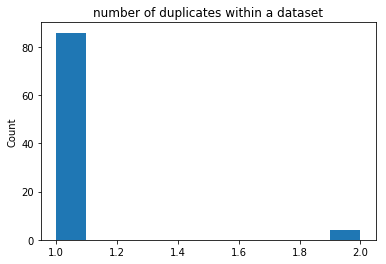

In [15]:
plt.hist(num_dupes);
plt.title('number of duplicates within a dataset');
plt.ylabel('Count');

It appears duplicates exist in several hundreds datasets. This is worrying :(

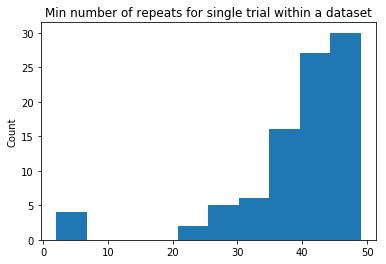

In [16]:
plt.hist(min_repeat);
plt.title('Min number of repeats for single trial within a dataset');
plt.ylabel('Count');

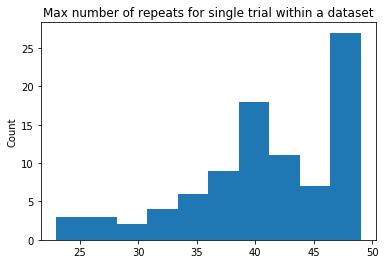

In [17]:
plt.hist(max_repeat);
plt.title('Max number of repeats for single trial within a dataset');
plt.ylabel('Count');

And when repeats occur, they occur quite a lot!

The next step would be to carefully count the number of trials per condition in FIRA, in DOTS and in dotsDB, and analyze the match/mismatch.

Counting trials in three databases (fira + dots + dotsDB) in the cell below takes 20 min.

In [18]:
# By this cell, make sure 'dots', 'fira' and 'dsets' are defined.
# dots and fira are pandas.DataFrame objects, dsets is the dict of counts
# The goal here is to build a dataframe with three columns: dots, fira, h5.
# Each row in this dataframe is a particular dataset in the hdf5 database
# each entry is the trial count for this particular dataset


index_as_list, dicts = [], []
counter = 0
for name in dsets:
    counter += 1
    if (counter % 10) == 0:
        print(counter)
    index_as_list.append(name)
    curr_dict = {}
    h5_count = count_h5(dsets[name][0])
    curr_dict['h5'] = h5_count
    if (counter % 10) == 0:
        print(f'counted h5 {h5_count}')
        
    fira_count = count_trials_fira(name, fira)
    curr_dict['fira'] = fira_count
    if (counter % 10) == 0:
        print(f'counted fira {fira_count}')
        
    dots_count = count_trials_dots(name, dots)
    curr_dict['dots'] = dots_count
    if (counter % 10) == 0:
        print(f'counted dots {dots_count}')
        print()
        
    dicts.append(curr_dict)
counts = pd.DataFrame(dicts, index=index_as_list)

10
counted h5 9
counted fira 9
counted dots 9

20
counted h5 8
counted fira 8
counted dots 8

30
counted h5 2
counted fira 2
counted dots 2

40
counted h5 2
counted fira 2
counted dots 2

50
counted h5 1
counted fira 1
counted dots 1

60
counted h5 8
counted fira 8
counted dots 8

70
counted h5 2
counted fira 2
counted dots 2

80
counted h5 27
counted fira 27
counted dots 27

90
counted h5 5
counted fira 5
counted dots 5



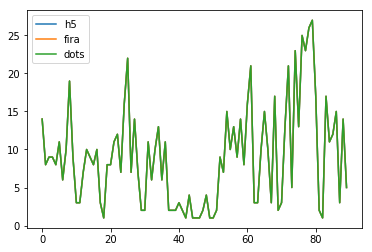

In [19]:
plt.plot(range(len(index_as_list)), counts['h5'], label='h5')
plt.plot(range(len(index_as_list)), counts['fira'], label='fira')
plt.plot(range(len(index_as_list)), counts['dots'], label='dots')
plt.legend()

In [20]:
h5_vs_fira = counts[counts['h5'] != counts['fira']].copy()

In [21]:
any(counts['fira'] != counts['dots'])

False

In [22]:
h5_vs_fira

,dots,fira,h5


In [24]:
counts

,dots,fira,h5
subj14/probCP0.3/coh0/ansleft/CPno/VD100/left/px,14,14,14
subj14/probCP0.3/coh0/ansleft/CPno/VD100/right/px,8,8,8
subj14/probCP0.3/coh0/ansleft/CPno/VD200/left/px,9,9,9
subj14/probCP0.3/coh0/ansleft/CPno/VD200/right/px,9,9,9
subj14/probCP0.3/coh0/ansleft/CPno/VD250/left/px,8,8,8
subj14/probCP0.3/coh0/ansleft/CPno/VD250/right/px,11,11,11
subj14/probCP0.3/coh0/ansleft/CPno/VD300/left/px,6,6,6
subj14/probCP0.3/coh0/ansleft/CPno/VD300/right/px,10,10,10
subj14/probCP0.3/coh0/ansleft/CPno/VD400/left/px,19,19,19
subj14/probCP0.3/coh0/ansleft/CPno/VD400/right/px,9,9,9
